In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import pydensecrf.densecrf as dcrf

In [2]:
INPUT_PATH = 'D:/Datasets/penguinguy/%03d%03d.png'

In [3]:
CAMERA_NUMBER = 8
IMAGE_NUMBER = 0
TOTAL_IMAGE_PER_CAMERA = 40
THESHOLD_RATIO = 0.05

In [4]:
def get_diff_mask(camerea_id,current_shot):
    previous_shot = (current_shot - 1) % TOTAL_IMAGE_PER_CAMERA
    # read image
    image_prev_uint = cv2.imread(INPUT_PATH % (camerea_id,previous_shot)) 
    image_current_uint = cv2.imread(INPUT_PATH % (camerea_id,current_shot)) 
    # convert to RGB
    image_prev_uint = cv2.cvtColor(image_prev_uint,cv2.COLOR_BGR2RGB)
    image_current_uint = cv2.cvtColor(image_current_uint,cv2.COLOR_BGR2RGB)
    # rotate
    image_prev_uint = cv2.rotate(image_prev_uint, cv2.ROTATE_90_CLOCKWISE)
    image_current_uint = cv2.rotate(image_current_uint, cv2.ROTATE_90_CLOCKWISE)
    # convert to [0-1]
    image_prev =  image_prev_uint / 255.0
    image_current = image_current_uint / 255.0
    # difference mask between 2 images
    diff_mask = np.linalg.norm(image_current - image_prev, axis=-1)
    diff_mask = (diff_mask > THESHOLD_RATIO) * 1.0
    #remove noise from sensor (hope this not ruin image)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    denoised_mask = cv2.morphologyEx(diff_mask, cv2.MORPH_OPEN, kernel)
    return denoised_mask

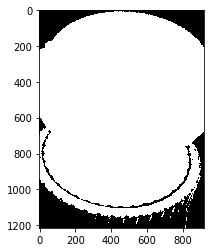

In [5]:
foreground_prob = get_diff_mask(CAMERA_NUMBER,0)
for i in range(1,40):
    foreground_prob = cv2.bitwise_or(foreground_prob,get_diff_mask(CAMERA_NUMBER,i))
plt.imshow(foreground_prob,cmap='gray')

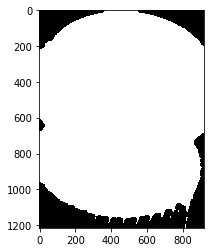

In [6]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(30,30))
mask_closed = cv2.morphologyEx(foreground_prob.copy(), cv2.MORPH_CLOSE, kernel)
plt.imshow(mask_closed,cmap='gray')

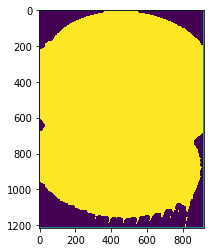

In [7]:
# find boundary (rectangle) of object 
mask_y, mask_x = np.nonzero(mask_closed)
min_x = np.min(mask_x)
max_x = np.max(mask_x)
min_y = np.min(mask_y)
max_y = np.max(mask_y)
mask_square = cv2.rectangle(mask_closed.copy(), (min_x,min_y), (max_x,max_y), (0.5), 10)
plt.imshow(mask_square)

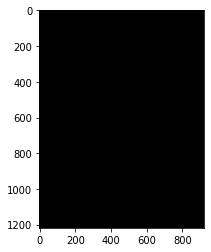

In [8]:
#flood fill to remove hole
image_flooded = (mask_closed.copy() * 255.0).astype(np.uint8)
image_height, image_width = image_flooded.shape[:2]
flood_mask = np.zeros((image_height+2,image_width+2),dtype=np.uint8)
has_flooded = False
# top bar
if min_y != 0:
    for i in range(image_flooded.shape[1]):
        if image_flooded[0,i] != 255:
            has_flooded = True
            cv2.floodFill(image_flooded, flood_mask, (i,0), 255)
# left bar
if min_x != 0:
    for i in range(image_flooded.shape[0]):
        if image_flooded[i,0] != 255:
            has_flooded = True
            cv2.floodFill(image_flooded, flood_mask, (0,i), 255)
# right bar
most_right = image_flooded.shape[1] -1
if max_x != most_right:
    for i in range(image_flooded.shape[0]):
        if image_flooded[i,most_right] != 255:
            has_flooded = True
            cv2.floodFill(image_flooded, flood_mask, (most_right,i), 255)
# bottom bar 
most_bottom = image_flooded.shape[0] -1
if max_y != most_bottom:
    for i in range(image_flooded.shape[1]):
        if image_flooded[most_bottom,i] != 255:
            has_flooded = True
            cv2.floodFill(image_flooded, flood_mask, (i,most_bottom), 255)
# we get background from floodfill
if has_flooded:
    background_mask = flood_mask[1:-1,1:-1]
else:
    background_mask = 1 - mask_closed
    is_background = background_mask == 1
# backgroud mm model 
default_image = cv2.imread(INPUT_PATH % (CAMERA_NUMBER,0)) 
    if USE_ROTATE_TO_IMAGE:
        default_image = cv2.rotate(default_image, ROTATE_DIRECTION)
    default_image = default_image / 255.0
plt.imshow(background_mask,cmap='gray')

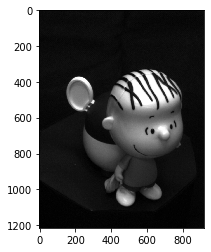

In [9]:
image_current_uint = cv2.imread(INPUT_PATH % (CAMERA_NUMBER,IMAGE_NUMBER)) 
image_current_uint = cv2.rotate(image_current_uint, cv2.ROTATE_90_CLOCKWISE)
image_gray = cv2.cvtColor(image_current_uint,cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray,cmap='gray')

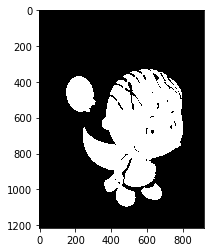

In [10]:
ret2,object_threshold = cv2.threshold(image_gray,30,255,cv2.THRESH_BINARY)
#ret2,object_threshold = cv2.threshold(image_gray,25,255,cv2.THRESH_TRIANGLE)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
object_threshold_opened = cv2.morphologyEx(object_threshold, cv2.MORPH_OPEN, kernel)
plt.imshow(object_threshold_opened,cmap='gray')

In [11]:
# normalize image to float32 [0,1]
image_current_float32 = image_current_uint / 255.0
# background_mask
unknown_mask = np.ones(background_mask.shape)
unknown_mask[background_mask == 1] = 0
unknown_mask[object_threshold_opened > 0] = 0
#Forground mm model
foreground_mm_model = cv2.ml.EM_create()
foreground_mm_model.setClustersNumber(4)
foreground_mm_model.trainEM(image_current_float32[object_threshold_opened > 0])
foreground_weights = foreground_mm_model.getWeights()
# prediction foreground
_, foreground_predicteds = foreground_mm_model.predict(image_current_float32[unknown_mask > 0])
foreground_probability = foreground_predicteds.dot(foreground_weights.T)
# backgroud mm model 
background_mm_model = cv2.ml.EM_create()
background_mm_model.setClustersNumber(4)
background_mm_model.trainEM(image_current_float32[background_mask == 1])
background_weights = background_mm_model.getWeights()
# prediction foreground
_, background_predicteds = background_mm_model.predict(image_current_float32[unknown_mask > 0])
background_probability = background_predicteds.dot(background_weights.T)

KeyboardInterrupt: 

In [0]:
# Foreground probability map
foreground_probability_map = np.zeros(background_mask.shape)
foreground_probability_map[unknown_mask > 0] = foreground_probability[:,0]
foreground_probability_map[object_threshold_opened > 0] = 1.0
foreground_probability_map[background_mask == 1] = 0.0
# Background probability map
background_probability_map = np.zeros(background_mask.shape)
background_probability_map[unknown_mask > 0] =  background_probability[:,0]
background_probability_map[object_threshold_opened > 0] = 0.0
background_probability_map[background_mask == 1] = 1.0

In [0]:
H, W = background_mask.shape
N_LABEL = 2
denseCRF = dcrf.DenseCRF2D(W, H, N_LABEL)
unary = np.dstack((foreground_probability_map,background_probability_map))
unary = -np.log(unary) # denseCRF require negative log probability
unary = unary.astype(np.float32) #require float32
unary = unary.transpose(2, 0, 1).reshape((N_LABEL,-1)) # unary need to be flat.
unary = np.ascontiguousarray(unary) #avoid cython problem :X
denseCRF.setUnaryEnergy(unary)

In [0]:
image_current_rgb = cv2.cvtColor(image_current_uint,cv2.COLOR_BGR2RGB)
denseCRF.addPairwiseGaussian(sxy=3, compat=3)
denseCRF.addPairwiseBilateral(sxy=80, srgb=13, rgbim=image_current_rgb, compat=10)
Q = denseCRF.inference(20)
segmented_mask = np.argmax(Q, axis=0).reshape((H,W))

In [0]:
plt.imshow(segmented_mask)

In [0]:
# With Dense CRF
output = image_current_rgb.copy()
output[segmented_mask == 1] = (0,255,0)
plt.imshow(output)

#WITHOUT DENSE CRF [JUST BACKGROUND PROCESS]
output = image_current_rgb.copy()
output[background_mask == 1] = (0,255,0)
plt.imshow(output)

In [0]:
mean_backgroud_color = np.mean(image_current_rgb[segmented_mask == 1],axis=0)

In [0]:
# With Dense CRF
output_image = image_current_rgb.copy()
output_image[segmented_mask == 1] = mean_backgroud_color
output_image = cv2.blur(output_image.copy(), (21,21))
new_mask = 1 - segmented_mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
eroded_mask = cv2.erode(new_mask.astype(np.uint8),kernel)
remain_foreground = eroded_mask == 1
output_image[remain_foreground] = image_current_rgb[remain_foreground]
plt.imshow(output_image)
#plt.imsave("test.png",blur_output)


output = image_current_rgb.copy()
blur_output[segmented_mask == 1] = mean_backgroud_color
blur_output = cv2.blur(output,(21,21))
new_mask = 1 - segmented_mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
eroded_mask = cv2.erode(new_mask.astype(np.uint8),kernel)
blur_output[eroded_mask == 1] = image_current_rgb[eroded_mask == 1]